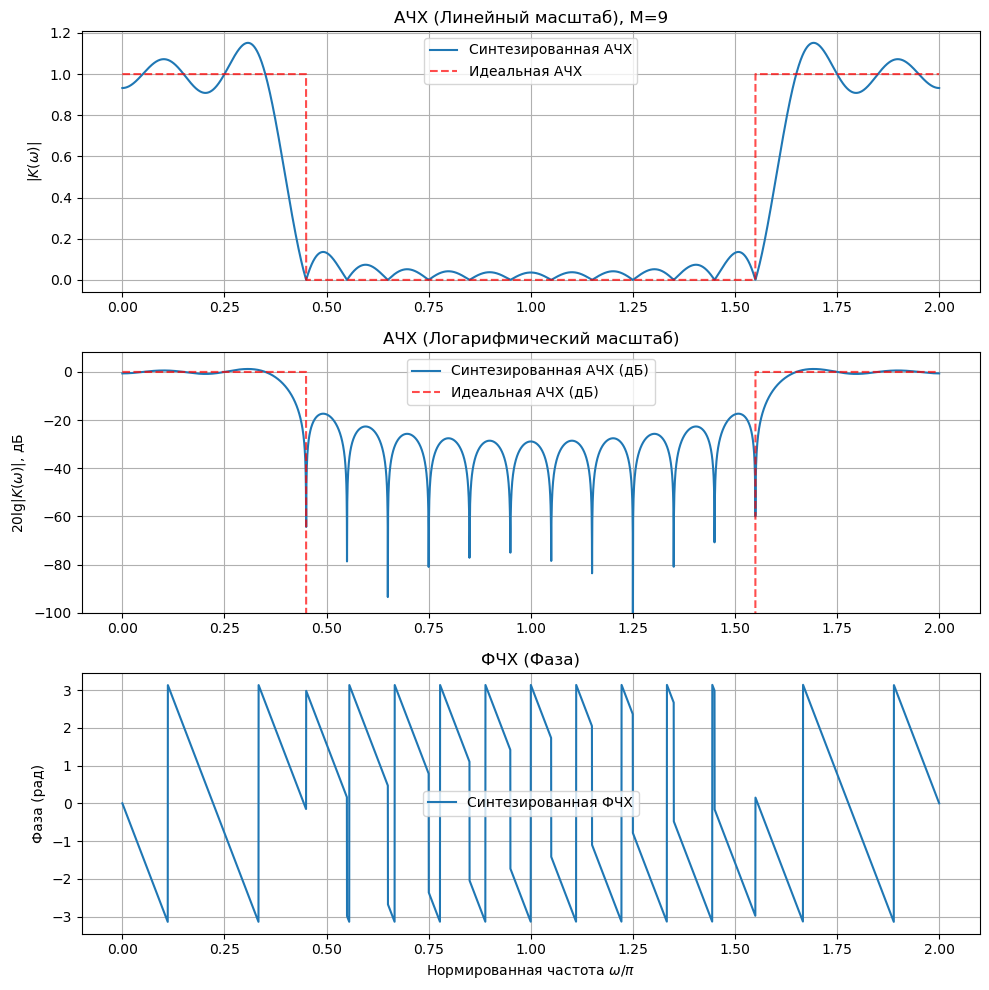

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры фильтра
w_p = [0, 0.45 * np.pi] # Полоса пропускания (верхняя граница 0.45*pi)
M = 9                   # Половина порядка фильтра

# Узлы частотной выборки
w_j = np.pi * (np.arange(0, M+1) + 0.5) / (M + 1)

# Желаемая АЧХ (1 в полосе пропускания, 0 иначе)
K_d = (w_p[0] <= w_j) & (w_j < w_p[1])
K_d = K_d.astype(float)

# Расчет коэффициентов фильтра
h = np.zeros(M + 1)
for k in range(M+1):
    # Формула (4.8):
    h[M - k] = (1 / (M + 1)) * np.sum(K_d * np.cos(w_j * k))

# Частотная ось
w = np.arange(0, 2*np.pi, 0.001)

# Расчет частотной характеристики
A = h[M] + sum(2 * h[M-k] * np.cos(w * k) for k in range(1, M + 1)) # (см. 4.7)

K = A * np.exp(-1j * w * M) # (см. 4.1)
mag = np.abs(K) # Линейная амплитуда

# Идеальная АЧХ
w_c = w_p[1] # Частота среза 0.45*pi
ideal_mag = np.where(
    ((w >= w_p[0]) & (w <= w_c)) | ((w >= (2 * np.pi - w_c)) & (w <= 2 * np.pi)), 
    1.0, 
    0.0
)

# Расчет в децибелах
threshold = 1e-7
mag_clipped = np.maximum(mag, threshold)
ideal_mag_clipped = np.maximum(ideal_mag, threshold)

# Перевод в дБ 
mag_db = 20 * np.log10(mag_clipped)
ideal_db = 20 * np.log10(ideal_mag_clipped)

# Идеальная ФЧХ (расчет оставлен, но не используется в построении)
ideal_phase = -w * M
ideal_phase = (ideal_phase + np.pi) % (2 * np.pi) - np.pi

# Построение графиков
plt.figure(figsize=(10, 10))

## АЧХ (Линейный масштаб)
plt.subplot(3, 1, 1)
plt.plot(w/np.pi, mag, label='Синтезированная АЧХ')
plt.plot(w/np.pi, ideal_mag, 'r--', alpha=0.7, label='Идеальная АЧХ')
plt.title(f'АЧХ (Линейный масштаб), M={M}')
plt.ylabel(r'$|K(\omega)|$')
plt.grid(True)
plt.legend()


## АЧХ (Логарифмический масштаб)
plt.subplot(3, 1, 2)
plt.plot(w/np.pi, mag_db, label='Синтезированная АЧХ (дБ)')
plt.plot(w/np.pi, ideal_db, 'r--', alpha=0.7, label='Идеальная АЧХ (дБ)')
plt.title('АЧХ (Логарифмический масштаб)')
plt.ylabel(r'$20 \lg|K(\omega)|$, дБ')
plt.ylim(bottom=-100)
plt.grid(True)
plt.legend()


## ФЧХ (Фаза)
plt.subplot(3, 1, 3)
plt.plot(w/np.pi, np.angle(K), label='Синтезированная ФЧХ')
# Строка для построения Идеальной линейной фазы удалена.
plt.title('ФЧХ (Фаза)')
plt.xlabel(r'Нормированная частота $\omega / \pi$')
plt.ylabel('Фаза (рад)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
import numpy as np

# function to optimize
def syntez(x_j, w_p, w_s, M):
    # Узлы частотной выборки
    w_j = np.pi * (np.arange(0, M+1) + 0.5) / (M + 1)
    
    # Определение принадлежности узлов к полосам
    flag_p = (w_j > w_p[0]) & (w_j <= w_p[1]) # Параметры фильтра
    flag_s = (w_j >= w_s[0]) & (w_j < w_s[1])
    
    # Формирование желаемой АЧХ (K_d)bandwithы
    flag_K_d = np.zeros(w_j.size)
    flag_K_d[flag_s] = 0          # 0 в полосе подавления
    flag_K_d[flag_p] = 1          # 1 в полосе пропускания
    # В переходной полосе используем значения x_j, которые подбирает оптимизатор
    flag_K_d[~(flag_s | flag_p)] = x_j
    
    h = np.zeros(M + 1)
    
    # calculation of filter coefficients
    for k in range(M+1):
        h[M-k] = (1.0 / (M + 1)) * np.sum(
            flag_K_d * np.cos(np.pi * k * (np.arange(0, M + 1) + 0.5) / (M + 1))
        )

    # calculating the frequency response, see (4.7) [cite: 31]
    # Используем lambda-функцию для вычисления АЧХ в любой точке w
    A_w = lambda w: h[M] + 2 * sum(
        h[M - k] * np.cos(w * k) for k in range(1, M + 1)
    )

    # calculating the synthesis error (минимаксный критерий) [cite: 35]
    W_s = np.arange(w_s[0], w_s[1], 0.001)
    W_p = np.arange(w_p[0], w_p[1], 0.001)
    
    # Ошибка отклонения от 1 в полосе пропускания
    Er_p = np.abs(1 - np.array([A_w(w) for w in W_p]))
    # Ошибка отклонения от 0 в полосе подавления
    Er_s = np.abs(0 - np.array([A_w(w) for w in W_s]))
    
    Er = np.concatenate([Er_p, Er_s])
    Er = np.max(np.abs(Er)) # Максимальная ошибка
    
    return Er, h

Optimization terminated successfully.
         Current function value: 0.072597
         Iterations: 14
         Function evaluations: 28
Оптимальное значение в переходной точке: [0.32724609]
Максимальная ошибка синтеза: 0.07259697583310865


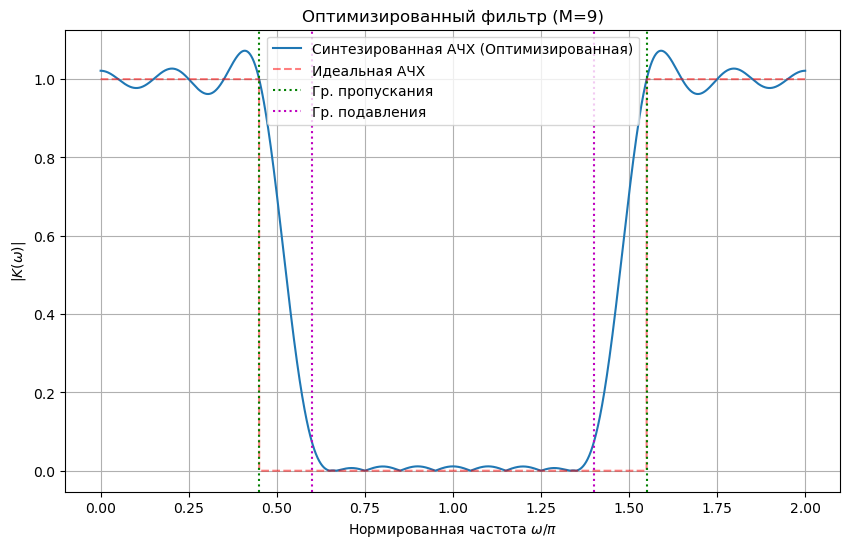

In [ ]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

# Параметры фильтра
w_p = [0, 0.45 * np.pi]     # Полоса пропускания
w_s = [0.60 * np.pi, np.pi] # Полоса подавления
M = 9 # M

# calculation of filter coefficients
w_j = np.pi*(np.arange(0,M+1) + 0.5)/(M + 1)
flag_p = (w_j > w_p[0]) & (w_j <= w_p[1])
flag_s = (w_j >= w_s[0]) & (w_j < w_s[1])

# initial value(s) of the frequency response in the transition band
# Есть одна точка в переходной полосе (j=5), начнем с 0.5
x = [0.5] 

# Запуск минимизации ошибки
# lambda t передает текущие x в функцию syntez и берет первый возвращаемый элемент (Er)
x = scipy.optimize.fmin(lambda t: syntez(t, w_p, w_s, M)[0], x0=x)

# Получаем финальные коэффициенты h с оптимальным x
Er, h = syntez(x, w_p, w_s, M)
    
w = np.arange(0, 2*np.pi, 0.001)

# calculating the frequency response
# Восстановление АЧХ (формула 4.7)
A = h[M] + sum(2 * h[M-k] * np.cos(w * k) for k in range(1, M + 1))

# Комплексная частотная характеристика (формула 4.1)
A = A * np.exp(-1j * w * M)

# Визуализация
print(f"Оптимальное значение в переходной точке: {x}")
print(f"Максимальная ошибка синтеза: {Er}")

plt.figure(figsize=(10, 6))
plt.plot(w/np.pi, np.abs(A), label='Синтезированная АЧХ (Оптимизированная)')

# Идеальная АЧХ
w_c = w_p[1] # Частота среза 0.45*pi
ideal = np.where(
    ((w >= w_p[0]) & (w <= w_c)) | ((w >= (2 * np.pi - w_c)) & (w <= 2 * np.pi)), 
    1.0, 
    0.0
)

plt.plot(w/np.pi, ideal, 'r--', alpha=0.5, label='Идеальная АЧХ')

# Рисуем границы полос
plt.axvline(w_p[1]/np.pi, color='g', linestyle=':', label='Гр. пропускания')
plt.axvline(w_s[0]/np.pi, color='m', linestyle=':', label='Гр. подавления')
plt.axvline((2*np.pi - w_p[1])/np.pi, color='g', linestyle=':')
plt.axvline((2*np.pi - w_s[0])/np.pi, color='m', linestyle=':')

plt.title(f'Оптимизированный фильтр (M={M})')
plt.xlabel(r'Нормированная частота $\omega / \pi$')
plt.ylabel(r'$|K(\omega)|$')
plt.grid(True)
plt.legend()
plt.show()

Целевые требования: delta_p <= 0.015, delta_s <= 0.045
------------------------------------------------------------
M =  9 | Точек в перех. полосе: 1 | Ошибка: 0.07260
M = 10 | Точек в перех. полосе: 2 | Ошибка: 0.03611
M = 11 | Точек в перех. полосе: 2 | Ошибка: 0.03023
M = 12 | Точек в перех. полосе: 2 | Ошибка: 0.02039
M = 13 | Точек в перех. полосе: 2 | Ошибка: 0.01599
M = 14 | Точек в перех. полосе: 2 | Ошибка: 0.01271
------------------------------------------------------------
НАЙДЕНО РЕШЕНИЕ
Минимальный порядок фильтра N = 2*M = 28 (M=14)
Финальная ошибка: 0.012711


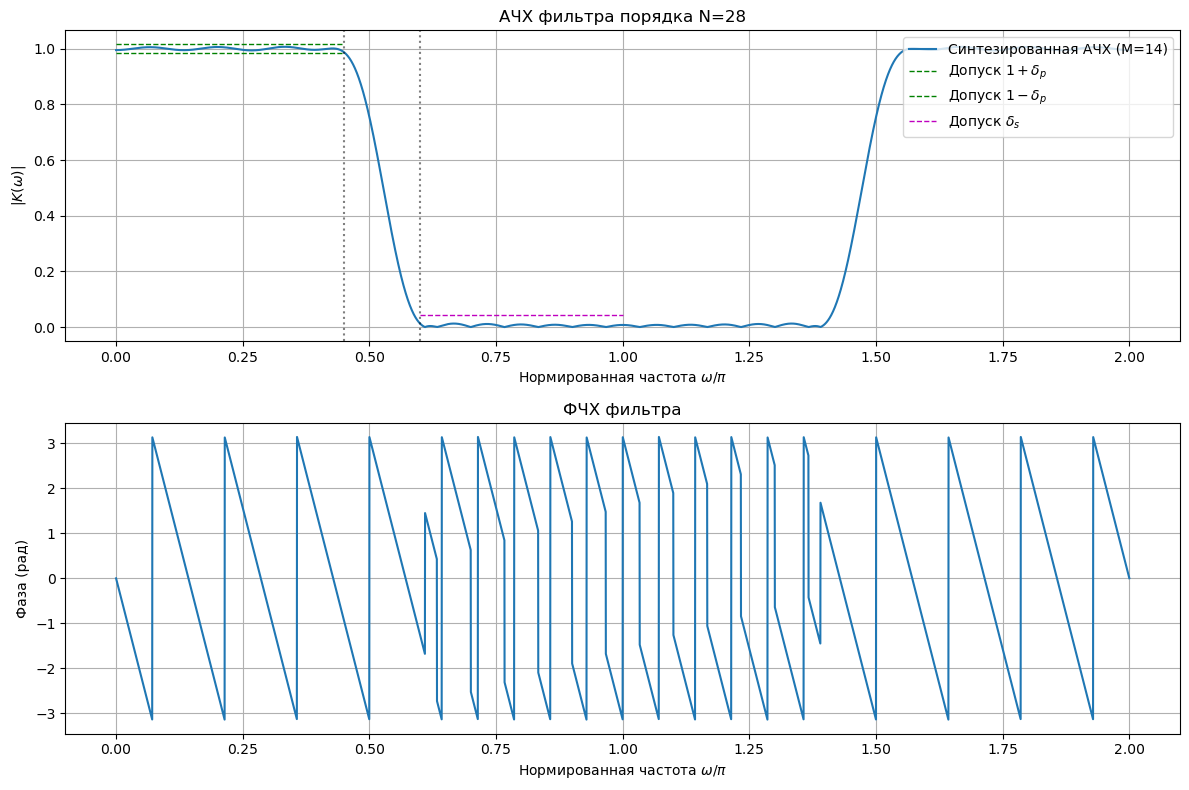

In [6]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

# Параметры
w_p = [0, 0.45 * np.pi]
w_s = [0.60 * np.pi, np.pi]
delta_p = 0.0150  # Требование в полосе пропускания
delta_s = 0.045   # Требование в полосе подавления

# Начнем с M = 9
found_M = None
final_h = None
final_Er = None

print(f"Целевые требования: delta_p <= {delta_p}, delta_s <= {delta_s}")
print("-" * 60)

# Цикл поиска минимального порядка
for M in range(9, 50):  # Ищем M от 9 до 50
    # Рассчитываем узлы для текущего M
    w_j = np.pi * (np.arange(0, M + 1) + 0.5) / (M + 1)
    
    # Определяем, какие точки попали в переходную полосу
    is_pass = (w_j > w_p[0]) & (w_j <= w_p[1])
    is_stop = (w_j >= w_s[0]) & (w_j < w_s[1])
    is_transition = ~(is_pass | is_stop)
    
    num_transition_points = np.sum(is_transition)
    
    # Если точек в переходной полосе нет, оптимизировать нечего,
    # но мы все равно можем посчитать ошибку (x=[]).
    # Если точки есть, задаем начальное приближение 0.5 для каждой.
    x0 = [0.5] * num_transition_points
    
    # Запуск оптимизации
    # Если x0 пустой, fmin может ругаться, поэтому добавим проверку
    if num_transition_points > 0:
        x_opt = scipy.optimize.fmin(lambda t: syntez(t, w_p, w_s, M)[0], x0=x0, disp=False)
    else:
        x_opt = []

    # Получаем характеристики фильтра с оптимальными (или пустыми) параметрами
    Er, h = syntez(x_opt, w_p, w_s, M)
    
    # В функции syntez возвращается общая максимальная ошибка.
    # Для строгости проверим, удовлетворяет ли она самому жесткому требованию.
    # (Так как Er = max(error_p, error_s), если Er < delta_p, то и подавно < delta_s)
    
    print(f"M = {M:2d} | Точек в перех. полосе: {num_transition_points} | Ошибка: {Er:.5f}")
    
    if Er <= delta_p: # Сравниваем с самым строгим условием (0.015)
        found_M = M
        final_h = h
        final_Er = Er
        print("-" * 60)
        print(f"НАЙДЕНО РЕШЕНИЕ")
        print(f"Минимальный порядок фильтра N = 2*M = {2*M} (M={M})")
        print(f"Финальная ошибка: {Er:.6f}")
        break

# Построение графиков для найденного фильтра
if found_M is not None:
    w = np.arange(0, 2 * np.pi, 0.001)
    
    # Восстановление АЧХ
    A = final_h[found_M] + sum(2 * final_h[found_M - k] * np.cos(w * k) for k in range(1, found_M + 1))
    H = A * np.exp(-1j * w * found_M)
    mag = np.abs(H)
    phase = np.angle(H)
    
    plt.figure(figsize=(12, 8))
    
    # График АЧХ
    plt.subplot(2, 1, 1)
    plt.plot(w / np.pi, mag, label=f'Синтезированная АЧХ (M={found_M})')
    
    # Рисуем границы допусков
    plt.plot([0, w_p[1]/np.pi], [1+delta_p, 1+delta_p], 'g--', linewidth=1, label=r'Допуск $1+\delta_p$')
    plt.plot([0, w_p[1]/np.pi], [1-delta_p, 1-delta_p], 'g--', linewidth=1, label=r'Допуск $1-\delta_p$')
    plt.plot([w_s[0]/np.pi, 1], [delta_s, delta_s], 'm--', linewidth=1, label=r'Допуск $\delta_s$')
    
    # Вертикальные границы полос
    plt.axvline(w_p[1]/np.pi, color='k', linestyle=':', alpha=0.5)
    plt.axvline(w_s[0]/np.pi, color='k', linestyle=':', alpha=0.5)
    
    plt.title(f'АЧХ фильтра порядка N={2*found_M}')
    plt.ylabel(r'$|K(\omega)|$')
    plt.xlabel(r'Нормированная частота $\omega / \pi$')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # plt.ylim(0.95, 1.05) 

    # График ФЧХ
    plt.subplot(2, 1, 2)
    plt.plot(w / np.pi, phase)
    plt.title('ФЧХ фильтра')
    plt.ylabel('Фаза (рад)')
    plt.xlabel(r'Нормированная частота $\omega / \pi$')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print("Не удалось найти подходящий порядок в заданном диапазоне.")

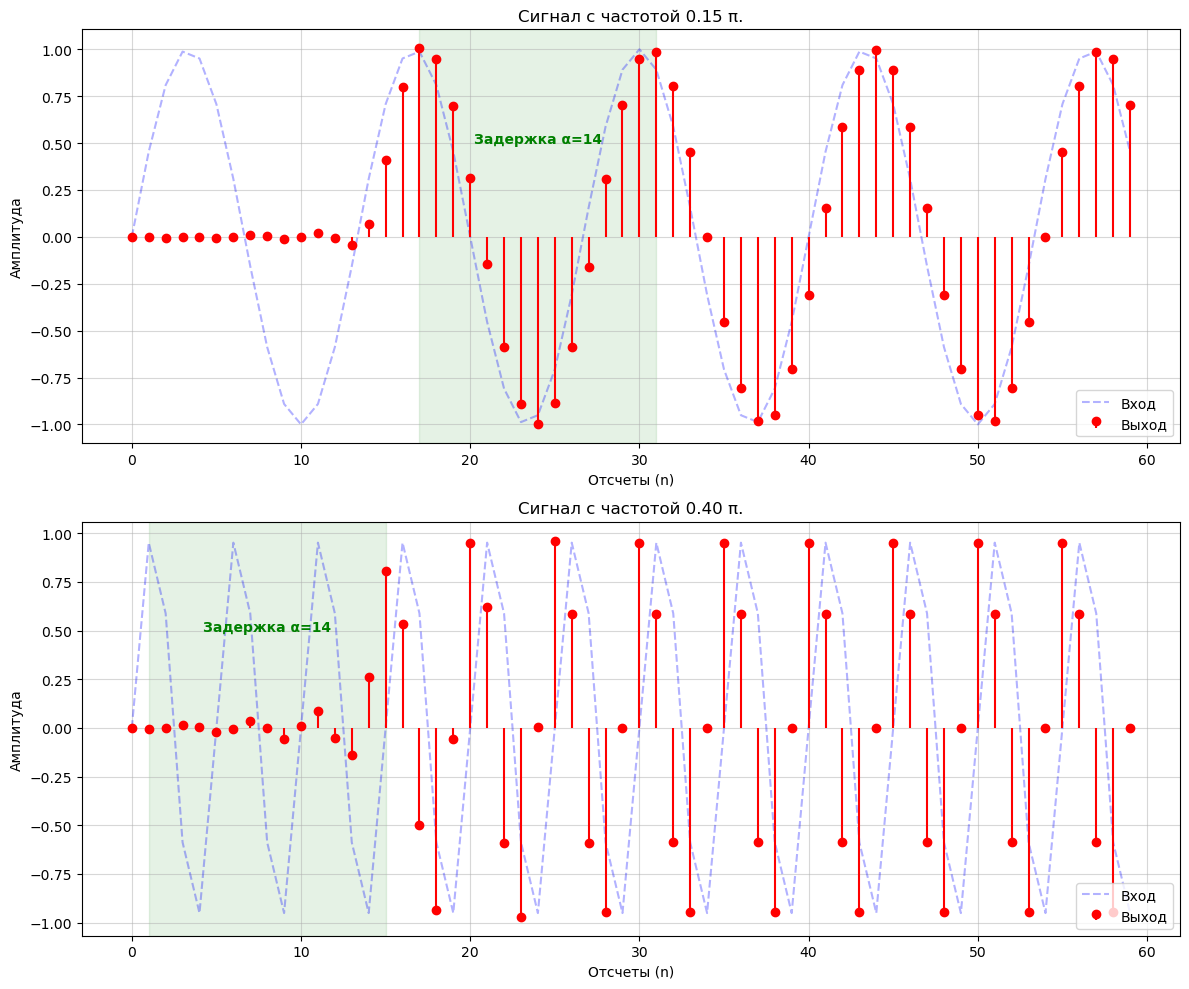

In [7]:
import numpy as np
import scipy.optimize
import scipy.signal
import matplotlib.pyplot as plt

# Параметры
M = 14  # Минимальный порядок
w_p = [0, 0.45 * np.pi]
w_s = [0.60 * np.pi, np.pi]
omega_x_list = [0.15 * np.pi, 0.40 * np.pi] 

# Восстановление коэффициентов
w_j = np.pi * (np.arange(0, M + 1) + 0.5) / (M + 1)
is_pass = (w_j > w_p[0]) & (w_j <= w_p[1])
is_stop = (w_j >= w_s[0]) & (w_j < w_s[1])
num_transition = np.sum(~(is_pass | is_stop))

# Оптимизация
x0 = [0.5] * num_transition
if num_transition > 0:
    x_opt = scipy.optimize.fmin(lambda t: syntez(t, w_p, w_s, M)[0], x0=x0, disp=False)
else:
    x_opt = []

# Получаем половинку h
_, h_half = syntez(x_opt, w_p, w_s, M)

# Собираем полный фильтр (зеркально отражаем h)
b = np.concatenate([h_half[:-1], h_half[::-1]])
a = [1.0]

# Проверка задержки сигнала
n = np.arange(0, 60) 

plt.figure(figsize=(12, 10))

for i, wx in enumerate(omega_x_list):
    # Генерируем синус
    x_in = np.sin(wx * n)
    # Фильтруем
    y_out = scipy.signal.lfilter(b, a, x_in)
    
    plt.subplot(2, 1, i + 1)
    
    # Входной сигнал
    plt.plot(n, x_in, 'b--', alpha=0.3, label='Вход')
    # Выходной сигнал
    plt.stem(n, y_out, linefmt='r-', markerfmt='ro', basefmt=' ', label='Выход')
    
    # Визуализация задержки
    peak_idx = np.argmax(x_in[:20])     # Пик на входе
    delayed_peak = peak_idx + M         # Ожидаемый пик на выходе
    
    plt.axvspan(peak_idx, delayed_peak, color='green', alpha=0.1)
    plt.annotate(f'Задержка α={M}', 
                 xy=(peak_idx + M/2, 0.5), 
                 ha='center', color='green', fontweight='bold')

    plt.title(f'Сигнал с частотой {wx/np.pi:.2f} π.')
    
    plt.xlabel('Отсчеты (n)')
    plt.ylabel('Амплитуда')
    plt.grid(True, alpha=0.5)
    plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

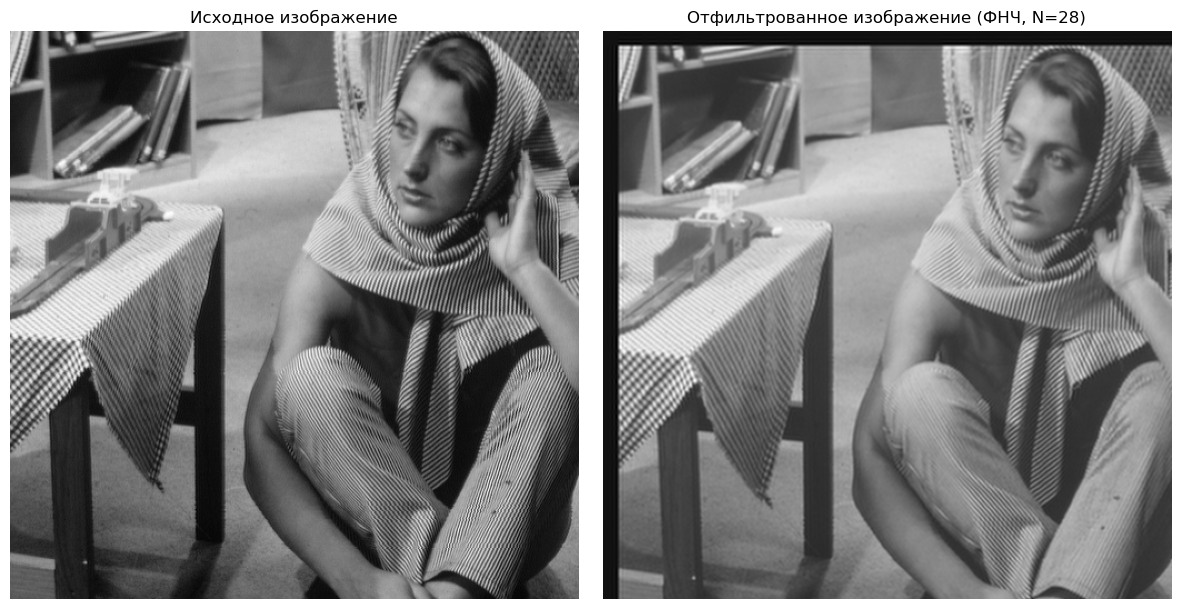


Объяснение результата
1. Наш фильтр является Фильтром Нижних Частот (ФНЧ) с частотой среза 0.45π.
2. ФНЧ пропускает плавные переходы (низкие частоты) и подавляет резкие детали и шум (высокие частоты).
3. В результате изображение становится сглаженным (размытым), так как из него удаляются высокочастотные компоненты.
4. Симметричный КИХ-фильтр гарантирует отсутствие фазовых искажений (линейная фаза), сохраняя форму объектов.


In [30]:
import numpy as np
import scipy.optimize
import scipy.signal
import matplotlib.pyplot as plt

# Параметры фильтра
M = 14
w_p = [0, 0.45 * np.pi]
w_s = [0.60 * np.pi, np.pi]

# Восстановление коэффициентов фильтра
w_j = np.pi * (np.arange(0, M + 1) + 0.5) / (M + 1)
is_pass = (w_j > w_p[0]) & (w_j <= w_p[1])
is_stop = (w_j >= w_s[0]) & (w_j < w_s[1])
num_transition = np.sum(~(is_pass | is_stop))

x0 = [0.5] * num_transition
if num_transition > 0:
    x_opt = scipy.optimize.fmin(lambda t: syntez(t, w_p, w_s, M)[0], x0=x0, disp=False)
else:
    x_opt = []
_, h_half = syntez(x_opt, w_p, w_s, M)
b = np.concatenate([h_half[:-1], h_half[::-1]])
a = [1.0]

# Загрузка и подготовка изображения
IMAGE_PATH = 'var5.png' 
img_data = plt.imread(IMAGE_PATH)

# Фильтрация по строкам (горизонтальная)
img_filtered_row = np.zeros_like(img)
for i in range(img.shape[0]):
    img_filtered_row[i, :] = scipy.signal.lfilter(b, a, img[i, :])

# Фильтрация по столбцам (вертикальная)
img_filtered_2d = np.zeros_like(img_filtered_row)
img_transposed = img_filtered_row.T
for j in range(img_transposed.shape[0]):
    img_filtered_2d[j, :] = scipy.signal.lfilter(b, a, img_transposed[j, :])

# Финальный результат - обратно транспонируем (для корректной формы)
img_filtered_2d = img_filtered_2d.T 

# Визуализация результата

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_filtered_2d, cmap='gray')
plt.title('Отфильтрованное изображение (ФНЧ, N=28)')
plt.axis('off')

plt.tight_layout()
plt.show()

print("\nОбъяснение результата")
print("1. Наш фильтр является Фильтром Нижних Частот (ФНЧ) с частотой среза 0.45π.")
print("2. ФНЧ пропускает плавные переходы (низкие частоты) и подавляет резкие детали и шум (высокие частоты).")
print("3. В результате изображение становится сглаженным (размытым), так как из него удаляются высокочастотные компоненты.")
print("4. Симметричный КИХ-фильтр гарантирует отсутствие фазовых искажений (линейная фаза), сохраняя форму объектов.")